In [2]:
#import all the csv data
import pandas as pd
from datetime import datetime,timedelta

In [3]:
users = pd.read_csv('takehome_users.csv',encoding="ISO-8859-1")

In [4]:
print(users.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [5]:
user_engagement = pd.read_csv('takehome_user_engagement.csv',encoding="ISO-8859-1")
user_engagement['time_stamp'] =  pd.to_datetime(user_engagement.time_stamp,format='%Y-%m-%d %X')

In [6]:
print(user_engagement.head())

           time_stamp  user_id  visited
0 2014-04-22 03:53:30        1        1
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1


In [105]:
UserAdoption = pd.DataFrame(pd.unique(user_engagement.user_id),columns=["user_id"])
UserAdoption['active'] = False
print(UserAdoption.head())

   user_id  active
0        1   False
1        2   False
2        3   False
3        4   False
4        5   False


In [106]:
for user, activeStatus in UserAdoption.iterrows():
    #print(user)
    if len(user_engagement[user_engagement.user_id==user])>3:
        minTime_diff = timedelta(days=99)
        tempArray = user_engagement[user_engagement.user_id==user].reset_index()
        for place in range(len(tempArray)-2):
            #print('place: ',place)
            #print(tempArray)
            time_dif = (tempArray.loc[place+2].time_stamp-tempArray.loc[place].time_stamp)
            if (minTime_diff > time_dif):
                minTime_diff = time_dif
        if minTime_diff <= timedelta(days=7):
            UserAdoption.loc[user,'active'] = True

In [107]:
print(UserAdoption.head())
print(len(UserAdoption))
print(UserAdoption.active.sum())

   user_id  active
0        1   False
1        2   False
2        3    True
3        4   False
4        5   False
8823
1199


solve to see if user is active from engagement -> only then merge

In [184]:
data = users.set_index('object_id').join(UserAdoption.set_index('user_id'),how='inner')

In [185]:
data=data.reset_index().drop('index',axis=1)

In [186]:
print(data.head())

         creation_time               name                       email  \
0  2014-04-22 03:53:30     Clausen August    AugustCClausen@yahoo.com   
1  2013-11-15 03:45:04      Poole Matthew      MatthewPoole@gustr.com   
2  2013-03-19 23:14:52  Bottrill Mitchell  MitchellBottrill@gustr.com   
3  2013-05-21 08:09:28    Clausen Nicklas   NicklasSClausen@yahoo.com   
4  2013-01-17 10:14:20          Raw Grace          GraceRaw@yahoo.com   

  creation_source  last_session_creation_time  opted_in_to_mailing_list  \
0    GUEST_INVITE                1.398139e+09                         1   
1      ORG_INVITE                1.396238e+09                         0   
2      ORG_INVITE                1.363735e+09                         0   
3    GUEST_INVITE                1.369210e+09                         0   
4    GUEST_INVITE                1.358850e+09                         0   

   enabled_for_marketing_drip  org_id  invited_by_user_id  active  
0                           0      11     

Use all but name to predict active

need to change formats of these
XXX time-> ints
XXX name-> elim
email-> extract site ->to categorical
creation_source-> to categorical

In [187]:
data['creation_time'] = pd.to_datetime(data.creation_time,format='%Y-%m-%d %X')
data['creation_year'] = pd.Series([date.year for date in data['creation_time']])
data['creation_month'] = pd.Series([date.month for date in data['creation_time']])
data['creation_day'] = pd.Series([date.day for date in data['creation_time']])
data['creation_hour'] = pd.Series([date.hour for date in data['creation_time']])
#data['creation_min'] = pd.Series([date.minute for date in data['creation_time']])
#data['creation_sec'] = pd.Series([date.second for date in data['creation_time']])

In [188]:
import re
def extractEmailSite(email=None):
    if email != None:
        site = re.search('@(.+?)\.', email).group(1)
        return site
    else:
        return None
data['email_site'] = pd.Series([extractEmailSite(email) for email in data['email']])

In [189]:
data['email_site_cat'] = data['email_site'].astype("category").cat.codes
data['creation_source_cat'] = data['creation_source'].astype("category").cat.codes

In [190]:
encoded_data = data.drop('email_site',axis=1).drop('creation_source',axis=1)\
                   .drop('name',axis=1).drop('creation_time',axis=1)\
                   .drop('email',axis=1).drop('org_id',axis=1)
print(encoded_data.head())

   last_session_creation_time  opted_in_to_mailing_list  \
0                1.398139e+09                         1   
1                1.396238e+09                         0   
2                1.363735e+09                         0   
3                1.369210e+09                         0   
4                1.358850e+09                         0   

   enabled_for_marketing_drip  invited_by_user_id  active  creation_year  \
0                           0             10803.0   False           2014   
1                           0               316.0   False           2013   
2                           0              1525.0    True           2013   
3                           0              5151.0   False           2013   
4                           0              5240.0   False           2013   

   creation_month  creation_day  creation_hour  email_site_cat  \
0               4            22              3             762   
1              11            15              3          

In [191]:
encoded_data.isnull().sum()

last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
invited_by_user_id            4047
active                           0
creation_year                    0
creation_month                   0
creation_day                     0
creation_hour                    0
email_site_cat                   0
creation_source_cat              0
dtype: int64

In [192]:
encoded_data['invited_by_user_id'] = encoded_data['invited_by_user_id'].fillna(value = 0)

In [193]:
#import needed functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [194]:
#randomly split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(\
    encoded_data.drop('active',axis=1),\
    encoded_data.active, \
    test_size=0.33, \
    random_state=42)

#instatiate and train classifier
clf = RandomForestClassifier()
#clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)

print('Training Report')
report = classification_report(y_true = np.array(y_train), y_pred = predictions)
print(report)
print('Testing Report')
predictions = clf.predict(X_test)
report = classification_report(y_true = np.array(y_test), y_pred = predictions)
print(report)

Training Report
             precision    recall  f1-score   support

      False       0.97      1.00      0.99      5100
       True       1.00      0.84      0.91       811

avg / total       0.98      0.98      0.98      5911

Testing Report
             precision    recall  f1-score   support

      False       0.87      0.99      0.93      2524
       True       0.24      0.02      0.03       388

avg / total       0.78      0.86      0.81      2912



Clearly this model is not great on the testing data but it still should show a couple of the most important features.

Feature ranking:
1. last_session_creation_time (0.251332)
2. creation_day (0.156761)
3. creation_hour (0.152854)
4. invited_by_user_id (0.132619)
5. creation_month (0.097358)
6. email_site_cat (0.090482)
7. creation_source_cat (0.055079)
8. creation_year (0.027261)
9. opted_in_to_mailing_list (0.021879)
10. enabled_for_marketing_drip (0.014375)


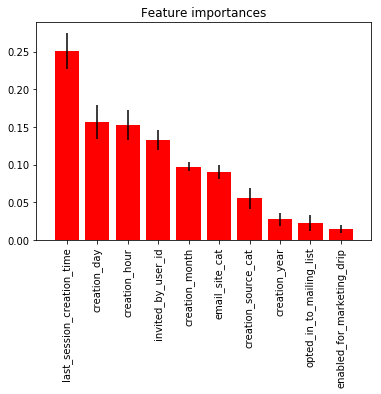

In [195]:
#back calculate which features have the highest predictive importance for retention
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns.values[indices[f]], importances[indices[f]]))
    #print("%d. %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
#plt.xticks(X_train.columns.values, indices)
plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

This shows that the Last session creation time is by far the most important feature. The next is when the account was created and who invited them or if they weren't invited at all. Users of some email sites are more likely to be retained